<h1>Word2Vec-based QA model trained from scratch<h1>

Using the SQuAD dataset:https://huggingface.co/datasets/rajpurkar/squad (including contexts)

Example queries from the trained model:
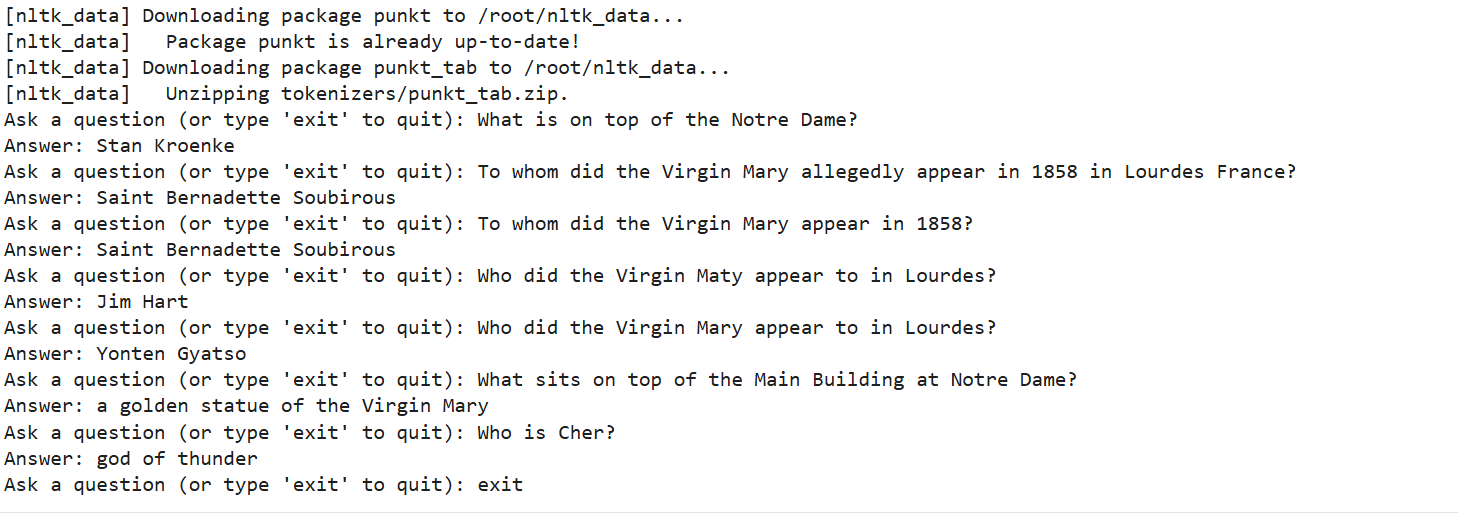


More example queries from the trained model:
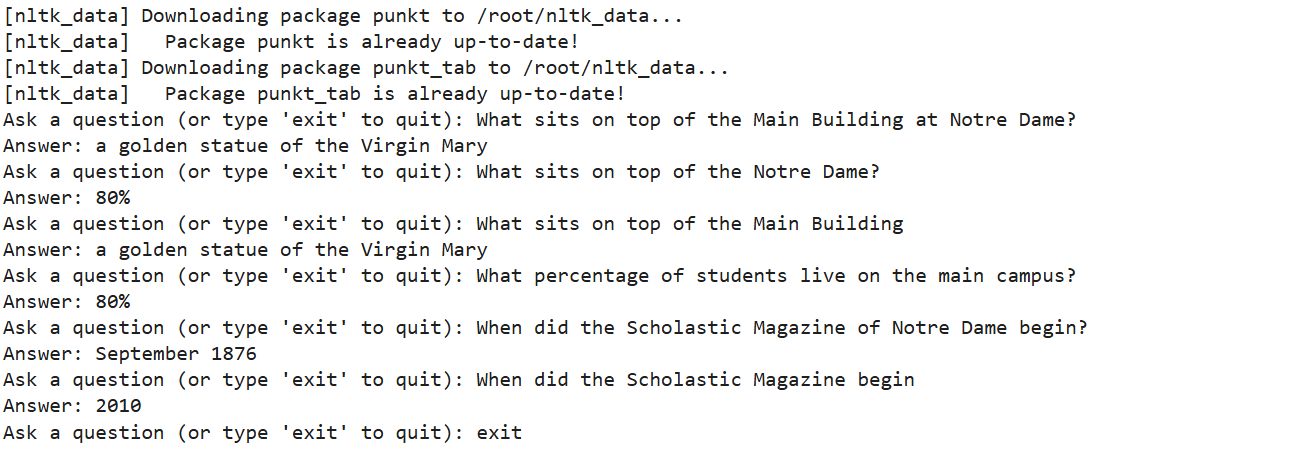

Example queries from training with only 500 lines of data (the previous examples used 50000):
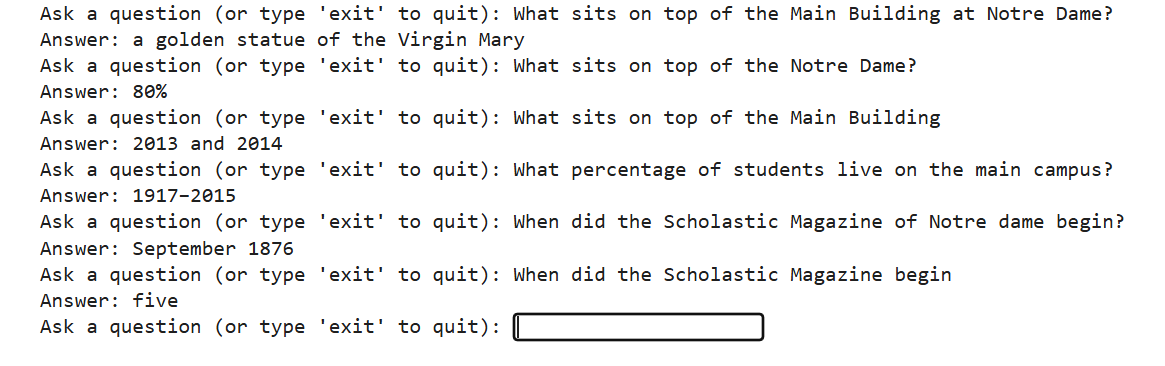

In [ ]:
import gensim
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, f1_score
from nltk.tokenize import word_tokenize
import nltk
from datasets import load_dataset

# Download NLTK data files (for tokenization)
nltk.download('punkt')
nltk.download('punkt_tab')

# Load SQuAD Dataset using the datasets library
squad_data = load_dataset("squad")
squad_data = squad_data["train"].select(range(50000))

# Extract contexts, questions, and answers from the SQuAD dataset
def parse_squad(data):
    contexts = []
    questions = []
    answers = []

    for entry in data:
        context = entry['context']
        question = entry['question']
        if entry['answers']['text']:
            # Take the first answer (SQuAD often provides multiple answers per question)
            answer = entry['answers']['text'][0]
            contexts.append(context)
            questions.append(question)
            answers.append(answer)
    return contexts, questions, answers

# Parse training data from the SQuAD dataset
contexts_raw, questions_raw, answers = parse_squad(squad_data)

# Preprocess the dataset
def preprocess_text(text):
    return word_tokenize(text.lower())

contexts = [preprocess_text(context) for context in contexts_raw]
questions = [preprocess_text(question) for question in questions_raw]

# Combine all texts for training Word2Vec
all_texts = contexts + questions

# Train a Word2Vec model
word2vec_model = Word2Vec(sentences=all_texts, vector_size=100, window=5, min_count=1, workers=4)

# Function to get the average Word2Vec embedding of a sentence
def get_sentence_embedding(sentence, model):
    embeddings = []
    for word in sentence:
        if word in model.wv:
            embeddings.append(model.wv[word])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

# Function to find the best-matching answer based on a question
def get_best_answer(input_question):
    input_question_tokens = preprocess_text(input_question)
    input_embedding = get_sentence_embedding(input_question_tokens, word2vec_model)

    best_answer = None
    best_similarity = -1

    for i, question in enumerate(questions):
        question_embedding = get_sentence_embedding(question, word2vec_model)
        similarity = cosine_similarity([input_embedding], [question_embedding])[0][0]

        if similarity > best_similarity:
            best_similarity = similarity
            best_answer = answers[i]

    return best_answer

# Evaluate the model
def evaluate_model():
    true_answers = []
    predicted_answers = []

    for i, question in enumerate(questions_raw):
        true_answers.append(answers[i])
        predicted_answers.append(get_best_answer(question))

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_answers, predicted_answers)
    f1 = f1_score(true_answers, predicted_answers, average='weighted')

    print("Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}")

# Example usage for evaluation
#evaluate_model()

# Interactive Q&A
while True:
    user_question = input("Ask a question (or type 'exit' to quit): ")
    if user_question.lower() == 'exit':
        break
    answer = get_best_answer(user_question)
    print(f"Answer: {answer}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Ask a question (or type 'exit' to quit): What is on top of the Notre Dame?
Answer: Stan Kroenke
Ask a question (or type 'exit' to quit): To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answer: Saint Bernadette Soubirous
Ask a question (or type 'exit' to quit): To whom did the Virgin Mary appear in 1858?
Answer: Saint Bernadette Soubirous
Ask a question (or type 'exit' to quit): Who did the Virgin Maty appear to in Lourdes?
Answer: Jim Hart
Ask a question (or type 'exit' to quit): Who did the Virgin Mary appear to in Lourdes?
Answer: Yonten Gyatso
Ask a question (or type 'exit' to quit): What sits on top of the Main Building at Notre Dame?
Answer: a golden statue of the Virgin Mary
Ask a question (or type 'exit' to quit): Who is Cher?
Answer: god of thunder
Ask a question (or type 'exit' to quit): exit
